In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
"""
Blackbox Attack

The way the blackbox attack works is as follows:
Since we do not know details about the model we are attacking, we train a "substitute model" to approximate the "target model".
This is done using a small sample of training data, labeled by the target model instead of using the ground-truth labels. 
In addition, we augment this training data using "Jacobian-based data augmentation" (TODO)
Finally, we use one of the regular attacks on the substitute model. Supposedly, an attack that works well against the substitute
will also work well against the target. 
"""

In [2]:
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image 
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset

import team36
from team36.mnist.data_loading import MNIST_Loader
from team36.mnist.vgg import VGG
from team36.mnist.cnn import CNN
from team36.attacks.fast_gradient_attack_data_set import FastSignGradientAttackDataSet
from team36.training import train, validate, accuracy, predict, predict_from_loader, do_training, load_or_train

DIR = '.'
DATA_DIR = f'{DIR}/data'

In [ ]:
"""
Step 1
Train the target model (aka the Oracle) on a large portion of the training data, or load a checkpoint
"""

In [3]:
mnist_loader = MNIST_Loader(DIR, DATA_DIR)

C:\Users\bkest\miniconda3\envs\cs7643-final-project-cpu\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
data = torchvision.datasets.MNIST(root=DATA_DIR, train=True, download=True, 
                                          transform=transforms.ToTensor())

In [5]:
oracle = VGG() # set the target model here
oracle_checkpoint = 'mnist-vgg.pth'
EPOCHS = 2
# TODO: define specific train/val split to avoid conflict with substitute model
load_or_train(oracle, oracle_checkpoint, epochs=2)
# if os.path.exists(oracle_checkpoint_path): # if trained checkpoint exists, load it
#     state_dict = torch.load(f"{DIR}/checkpoints/{checkpoint}", map_location=torch.device('cpu'))
#     model.load_state_dict(state_dict)
# else: # else, train the model
#     oracle_train_split, oracle_val_split = mnist_loader.train_val_split()
#     print(f"{len(oracle_train_split)} in training set")
#     print(f"{len(oracle_val_split)} in validation set")
#     do_training(oracle, training_split=oracle_train_split, validation_split=oracle_val_split, epochs=EPOCHS)

In [ ]:
"""
Step 2
Train the substitute model on a small portion of the training data, using the oracle's predictions as the labels

oracle pred full mnist
replace targets
train val split (small train)
"""

In [6]:
substitute = CNN()
substitute_checkpoint = 'substitute.pth'

In [7]:
loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=False, num_workers=2)

In [8]:
%%time
oracle_preds = predict_from_loader(oracle, loader)

C:\Users\bkest\miniconda3\envs\cs7643-final-project-cpu\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:115.)
  return torch._C._cuda_getDeviceCount() > 0
C:\Users\bkest\miniconda3\envs\cs7643-final-project-cpu\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mo

Wall time: 2min 34s


In [9]:
oracle_preds = oracle_preds.argmax(axis=1)

In [10]:
oracle_preds.shape

torch.Size([60000])

In [11]:
len(oracle_preds[oracle_preds != data.targets]) # check oracle preds mostly matches true labels

10914

In [14]:
data.targets = oracle_preds

100 in training set
100 in validation set
Epoch: [0][0/8]	Loss 1.3544 (1.3544)	Prec @1 0.6641 (0.6641)	
Epoch 0 | Training accuracy: 0.7419999837875366% | Validation accuracy: 0.75%
Epoch: [1][0/8]	Loss 1.2081 (1.2081)	Prec @1 0.8125 (0.8125)	
Epoch 1 | Training accuracy: 0.7820000052452087% | Validation accuracy: 0.7699999809265137%
Epoch: [2][0/8]	Loss 1.1510 (1.1510)	Prec @1 0.8672 (0.8672)	
Epoch 2 | Training accuracy: 0.8209999799728394% | Validation accuracy: 0.7400000095367432%
Epoch: [3][0/8]	Loss 1.2538 (1.2538)	Prec @1 0.7969 (0.7969)	
Epoch 3 | Training accuracy: 0.8069999814033508% | Validation accuracy: 0.75%
Epoch: [4][0/8]	Loss 1.2242 (1.2242)	Prec @1 0.7891 (0.7891)	
Epoch 4 | Training accuracy: 0.7900000214576721% | Validation accuracy: 0.7699999809265137%
Epoch: [5][0/8]	Loss 1.2124 (1.2124)	Prec @1 0.7734 (0.7734)	
Epoch 5 | Training accuracy: 0.8389999866485596% | Validation accuracy: 0.7799999713897705%
Epoch: [6][0/8]	Loss 1.1953 (1.1953)	Prec @1 0.8047 (0.8047)	


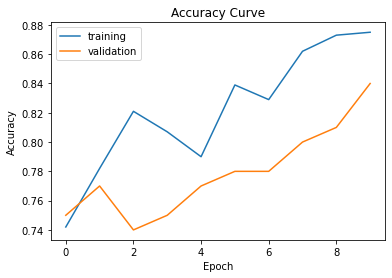

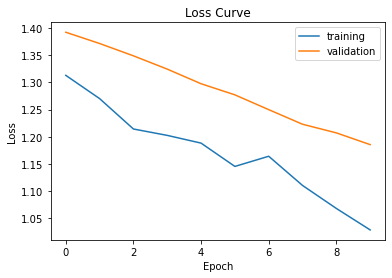

Best Validation Acccuracy: 0.8400


In [19]:
train_size = 100
train = Subset(data, range(train_size))
val = Subset(data, range(train_size, train_size*2)) # val split same size as train split
load_or_train(substitute, substitute_checkpoint, train_split=train, val_split=val, epochs=10)

In [ ]:
"""
Step 3
Generate attack data for the substitute model and test both models with it
"""

In [20]:
target = oracle
criterion = nn.CrossEntropyLoss()

In [21]:
"""Regular Test"""
test_set = torchvision.datasets.MNIST(root=DATA_DIR, train=False, download=True, 
                                      transform=transforms.ToTensor())

test_loader = torch.utils.data.DataLoader(test_set, batch_size=100, shuffle=False, num_workers=2)

substitute_test_accuracy, _, substitute_test_loss = validate(None, test_loader, substitute, criterion)
target_test_accuracy, _, target_test_loss = validate(None, test_loader, target, criterion)

print(f"Substitute Regular Test Accuracy is {substitute_test_accuracy}")
print(f"Substitute Regular Test Loss is {substitute_test_loss}")

print(f"Target Regular Test Accuracy is {target_test_accuracy}")
print(f"Target Regular Test Loss is {target_test_loss}")

Substitute Regular Test Accuracy is 0.6643000245094299
Substitute Regular Test Loss is 1.3816022872924805
Target Regular Test Accuracy is 0.8274999856948853
Target Regular Test Loss is 0.8391931653022766


In [24]:
"""Attack Test"""
attack_test_set = torchvision.datasets.MNIST(root=DATA_DIR, train=False, download=True, 
                                             transform=transforms.ToTensor())
attack_test_set = FastSignGradientAttackDataSet(attack_test_set, substitute, criterion, 
                                                               epsilon=0.25)
attack_test_loader = torch.utils.data.DataLoader(attack_test_set, batch_size=100, 
                                                 shuffle=False, num_workers=0)

substitute_attack_test_accuracy, _, substitute_attack_test_loss = validate(None, attack_test_loader, substitute, criterion)
target_attack_test_accuracy, _, target_attack_test_loss = validate(None, attack_test_loader, 
                                                                     target, criterion)

print(f"Substitute Attack Test Accuracy is {substitute_attack_test_accuracy}")
print(f"Substitute Attack Test Loss is {substitute_attack_test_loss}")

print(f"Target Attack Test Accuracy is {target_attack_test_accuracy}")
print(f"Target Attack Test Loss is {target_attack_test_loss}")

Substitute Attack Test Accuracy is 0.08290000259876251
Substitute Attack Test Loss is 2.5031323432922363
Target Attack Test Accuracy is 0.3978999853134155
Target Attack Test Loss is 1.8616756200790405
